# Utility algorithms:

### Recognize evolutions of the same clusers

**Metod:** Cosine simmilarity matrix, cluster alignment using local threshold

**Parameters:**
* Position
* Point count / avg
* Blair-Bliss (density) 
* Correlation coeffitience (roundness) 
* Linear trend direction 


# Phase 1: Outlier/novelty detection on sensors

### For whole map generate scores for each step's:

1) Novelty: In comparison to previous measurements from same calibration 

**Metod:**
    Streaming RRCF

**Parameters:**
* New points count / avg
* Lost points count / avg
* Number of new clusters / avg (Use cluster recognition algorithm)
* Number of lost clusters / avg
* New points in clusters count / avg
* Lost points in clusters count / avg

2) Outlierness : In comparison to other sensors / previous calibrations data

**Metod:** Batch RRCF

**Parameters:**
* Directional density imbalance (Steepness of maximum imbalance axis)
* Local density imbalance (Standard deviation of KNN distance sum)
* Total points count / total
* Number of clusters / avg
* Points in clusters / avg

# Phase 2: Sensor noise progression forecasting


### For each sensor forecast a set of measurements:

**Metod:** Holt-Winters

**Parameters:**
* Directional density imbalance (Steepness of maximum imbalance axis)
* Local density imbalance (Standard deviation of KNN distance sum)
* Total points count
* Number of clusters
* Points in clusters



In [1]:
!pip install rrcf

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rrcf
from sklearn.cluster import DBSCAN


/home/mwm/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Phase 0


### Simulated data generation

In [33]:
index = 0
lines = []
blobs = []



from velopix import make_line, make_blob, make_uniform, MaskMapGenerator, get_map_points

In [34]:
random_line = make_line(256, 256, np.abs(np.random.randint(40)))
random_line

array([[170, 225],
       [171, 225],
       [172, 225],
       [173, 225],
       [174, 226],
       [175, 226],
       [176, 226],
       [177, 226],
       [178, 226],
       [179, 226],
       [180, 226]])

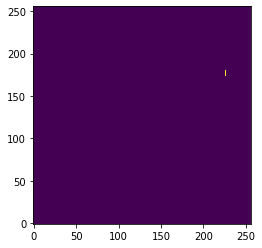

In [35]:
one_line_map=np.zeros((256,256))
amplifying_factor=300
for x, y in random_line:
    one_line_map[x, y] = amplifying_factor
one_line_map=np.zeros((256,256))
amplifying_factor=300
one_line_map[random_line[:,0], random_line[:,1]] = amplifying_factor
plt.imshow(one_line_map, interpolation="None", origin="lower")
plt.savefig('line_example.png')

In [36]:
random_blob = make_blob(n_samples=np.abs(np.random.randint(40)),size=256)
random_blob.T

array([[ 7, 24, 41, 25, 18, 24, 29, 23, 11, 23, 20, 28, 37, 24, 19, 30,
        34, 17, 17, 24],
       [80, 89, 77, 82, 77, 76, 73, 88, 95, 86, 81, 90, 83, 74, 76, 67,
        84, 86, 75, 84]])

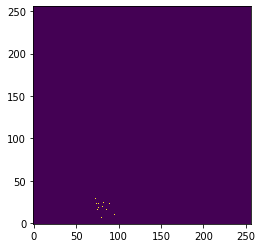

In [37]:
one_blob_map=np.zeros((256,256))
amplifying_factor=300
one_blob_map[random_blob[:,0], random_blob[:,1]] = amplifying_factor
plt.imshow(one_blob_map, interpolation="None", origin="lower")

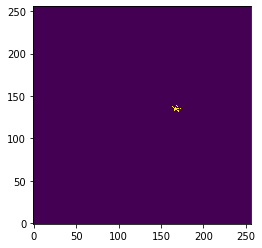

In [38]:
random_blob = make_blob(n_samples=np.abs(np.random.randint(40)),size=256)
one_blob_map=np.zeros((256,256))
amplifying_factor=300
one_blob_map[random_blob[:,0], random_blob[:,1]] = amplifying_factor
plt.imshow(one_blob_map, interpolation="None", origin="lower")
plt.savefig('blob_example.png')

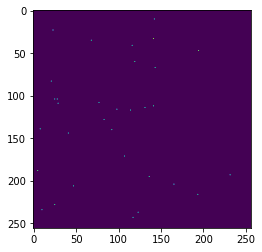

In [39]:
randmap = make_uniform()
randmap = np.maximum(np.zeros((256, 256)), make_uniform())

plt.imshow(randmap)

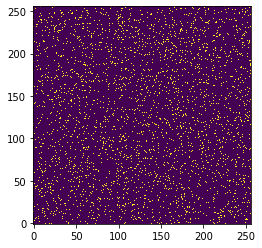

In [40]:
randmap2 = make_uniform(p=0.06)
plt.imshow(randmap2, interpolation='none', origin='lower')
plt.savefig('uniform_example.png')

In [41]:
np.unique(randmap) 

array([  0., 300.])

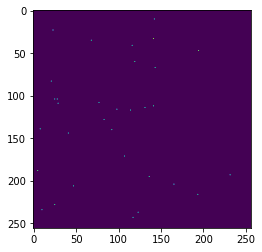

In [42]:
plt.imshow(randmap != 0.0)

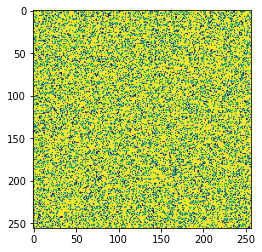

In [43]:
randmap = np.random.binomial(n=1, p=0.8,size=(256,256))
plt.imshow(randmap)

In [44]:

from velopix import MaskMapGenerator, cluster_simmilarity, get_clusters, get_cluster_array
    

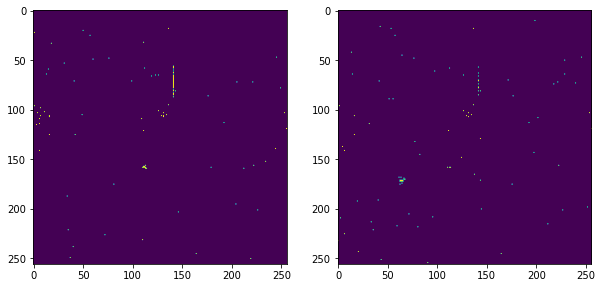

In [45]:
D = C = None
n = 0
m = 40
mgen = MaskMapGenerator(None, 0.5, 0.2)
for  i in mgen.generate(m):
    n += 1
    if n == m-4:
     C = i
    D = i
    
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

axis[0].imshow(C)
axis[1].imshow(D)

### Utility algorithms

In [46]:
A = B = None
n = 0
m = 40

mgen = MaskMapGenerator(None, 0.5, 0.2)
for  i in mgen.generate(m):
    n += 1
    if n == m-4:
        A = i
    B = i

dbscan = DBSCAN(5, min_samples=4)
simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(B, dbscan), get_clusters(A, dbscan))

# Comparing clustering algorithms

In [47]:
mgen = MaskMapGenerator(None, 0.5, 0.2)
n = 600
allmaps =  [m for m in mgen.generate(n)]

In [48]:
from sklearn.cluster import DBSCAN, OPTICS, Birch, MeanShift, AgglomerativeClustering
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

optics = OPTICS(eps= 5, min_samples=4, cluster_method="dbscan")
dbscan = DBSCAN(5, min_samples=4)
clfs = [optics, dbscan] 
clf_metrics = []

blobsets = { k: set(tuple(pair) for pair in v) for k, v in mgen.blobs.items()}
linesets = { k: set(tuple(pair) for pair in v) for k, v in mgen.lines.items()}

all_confs = []

for clf in tqdm(clfs):
    conf_matrices = []
    for i, m in tqdm(enumerate(allmaps)):
        clstrs = get_clusters(m, clf)
        arr = get_cluster_array(clstrs)
        map_points = get_map_points(m)
        generated_ground_clusters = []
        backsee = 8
        for kb, blob in mgen.blobs.items():
            if i >= kb and i - backsee < kb:
                generated_ground_clusters.append(blob)
        for lb, line in mgen.lines.items():
             if i >= lb and i - backsee < lb:
                generated_ground_clusters.append(line)
        generated_cluster_pixels = np.concatenate(generated_ground_clusters) if len(generated_ground_clusters)!=0 else np.array([])
        truth_set = set(tuple(pair) for pair in generated_cluster_pixels)
        nonzero_set = set(tuple(pair) for pair in map_points)
        if generated_ground_clusters:
            alld_a= map_points 
            alld_b = np.zeros((alld_a.shape[0], 3), dtype=int)
            alld_b[:,-2:] = alld_a
            match_ground = [tuple(x[-2:]) in truth_set for x in alld_b]
            alld_b[:,0][match_ground] = 1
            alld_b = np.array(sorted([tuple(x) for x in alld_b], key=lambda x: x[-2:]))
        clstrs[:,0][clstrs[:,0] != -1] = 1
        clstrs[:,0][clstrs[:,0] == -1] = 0
        if generated_ground_clusters:
            tn, fp, fn, tp = confusion_matrix(alld_b[:,0], clstrs[:,0], labels=[0,1]).ravel()
            conf_matrices.append((tn, fp, fn, tp))
    all_confs.append(conf_matrices)

    


In [50]:
conf_optics = np.array(all_confs[0])
conf_dbscan= np.array(all_confs[1])

In [51]:
from sklearn.cluster import DBSCAN, OPTICS, Birch, MeanShift, AgglomerativeClustering
from collections import defaultdict
from tqdm.notebook import tqdm

#optics = OPTICS(eps= 5, min_samples=4, cluster_method="dbscan")
optics = OPTICS(min_samples=4)
dbscan = DBSCAN(5, min_samples=4)
clfs = [optics, dbscan] 
clf_metrics = []

blobsets = { k: set(tuple(pair) for pair in v) for k, v in mgen.blobs.items()}
linesets = { k: set(tuple(pair) for pair in v) for k, v in mgen.lines.items()}
acc_blobs = []
acc_lines = []
all_metrics = []

for clf in tqdm(clfs):
    metrics = defaultdict(list)
    blob_acc = defaultdict(list)
    line_acc = defaultdict(list)
    allmaps_possible_clusterpoints = []
    acc, mm, recall = [], [], []
    for i, m in tqdm(enumerate(allmaps)):
        clstrs = get_clusters(m, clf)
        arr = get_cluster_array(clstrs)
        possible = []
        backsee = 20
        allclustered = set(tuple(pair) for pair in clstrs[clstrs[:,0] != -1][:,-2:])
        tn = len(set(tuple(pair) for pair in clstrs[clstrs[:,0] == -1][:,-2:]))
        all_pixels = set(tuple(pair) for pair in clstrs[:,-2:])
        for kb, blob in mgen.blobs.items():
            if i >= kb and i - backsee < kb:
                possible.append(blob)
        for lb, line in mgen.lines.items():
             if i >= lb and i - backsee < lb:
                possible.append(line)
        all_possible_pixels = np.concatenate(possible) if len(possible)!=0 else np.array([])
        all_found_pixels = np.concatenate(arr) if len(arr)!=0 else np.array([])
        data1 = set(tuple(pair) for pair in all_possible_pixels)
        data2 = set(tuple(pair) for pair in all_found_pixels)
        for kb, blob in mgen.blobs.items():
            if i >= kb and i - backsee < kb:
                if blobsets[kb]:
                    blob_acc[kb].append(len(allclustered & blobsets[kb])/len(data1))
        for lb, line in mgen.lines.items():
             if i >= lb and i - backsee < lb:
                if linesets[lb]:
                    line_acc[lb].append(len(allclustered & linesets[lb])/len(data1))

        if possible:
            alld_a= np.array(list(all_pixels)) 
            alld_b = np.zeros((alld_a.shape[0], 3), dtype=int)
            alld_b[:,-2:] = alld_a
            match = [tuple(x[-2:]) in data1 for x in alld_b]
            alld_b[:,0][match] = 1
            alld_b = np.array(sorted([tuple(x) for x in alld_b], key=lambda x: x[-2:]))
            allmaps_possible_clusterpoints.append(alld_b)
        else:
            allmaps_possible_clusterpoints.append([])
        tp = len(data1 & data2) # present in generated data in and in found in clusters
        fp = len(data2 - data1) # not present in generated, but found
        fn = len(data1 - data2) # generated in the data, but not found
        tn = len(all_pixels - data1)
        metrics['tp'].append(tp)
        metrics['fp'].append(fp)
        metrics['fn'].append(fn)
        metrics['tn'].append(tn)
        acc.append((tp+tn)/len(all_pixels))
        recall.append(tp/(tp+fn) if tp+fn!=0 else 0)
        mm.append(tp/len(all_pixels))
    clf_metrics.append((acc, recall, mm))
    acc_blobs.append(blob_acc)
    acc_lines.append(line_acc)
    all_metrics.append(metrics)
            
    


In [49]:
d = all_metrics[0]

summed_conf_mat = lambda x : {n:sum(x[n]) for n in ['tp', 'fn', 'fp', 'tn']}

def calc_fp_ratio(dat):
    met = summed_conf_mat(dat)
    return met['fp']/(met['fp']+ met['tn'])
    


NameError: name 'all_metrics' is not defined

In [28]:
print(calc_fp_ratio(all_metrics[0]))
print(calc_fp_ratio(all_metrics[1]))

0.38530114525830106
0.18461605718157775


In [29]:
print(calc_fp_ratio(all_metrics[0]))
print(calc_fp_ratio(all_metrics[1]))

0.38530114525830106
0.18461605718157775


In [30]:
[summed_conf_mat(all_metrics[i]) for i in range(2)]

[{'tp': 14573, 'fn': 107120, 'fp': 23382, 'tn': 37303},
 {'tp': 9707, 'fn': 111986, 'fp': 8446, 'tn': 37303}]

In [31]:
print(calc_fp_ratio(all_metrics[0]))
print(calc_fp_ratio(all_metrics[1]))

0.38530114525830106
0.18461605718157775


In [32]:
[summed_conf_mat(all_metrics[i]) for i in range(2)]

[{'tp': 14573, 'fn': 107120, 'fp': 23382, 'tn': 37303},
 {'tp': 9707, 'fn': 111986, 'fp': 8446, 'tn': 37303}]

In [33]:
def get_decay_plot(ind):
    fig, axe = plt.subplots(1,1, figsize=(8,6))
    liner, blobber = acc_lines[ind], acc_blobs[ind]
    for k,v in blobber.items():
        axe.plot(v,alpha=0.4)
    for k,v in liner.items():
        axe.plot(v, alpha=0.4)
    axe.set_xlim(0,19)
    axe.set_xticks(range(20)[::2])
    axe.set_ylim(0,0.20)

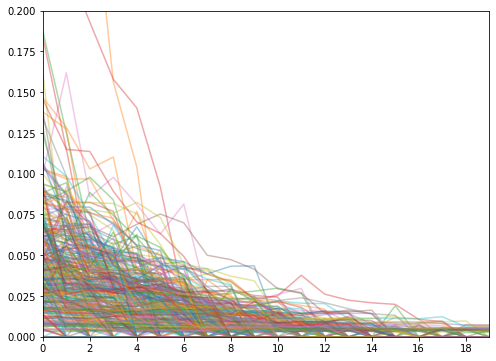

In [34]:
get_decay_plot(0)

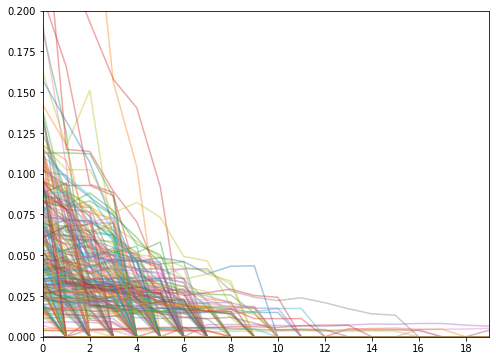

In [35]:
get_decay_plot(1)

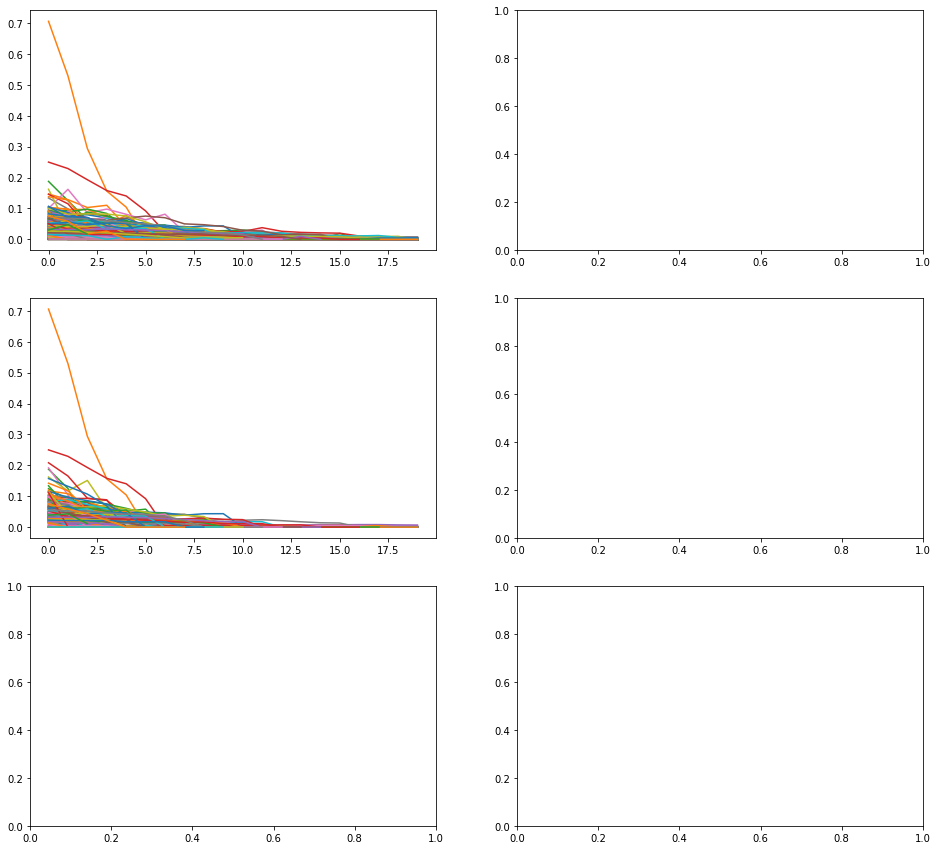

In [36]:
fig, axes = plt.subplots(3,2, figsize=(16,15))
for blobber, axe in zip(acc_blobs,axes):
    suma = 0
    for k,v in blobber.items():
        axe[0].plot(v)

IndexError: list index out of range

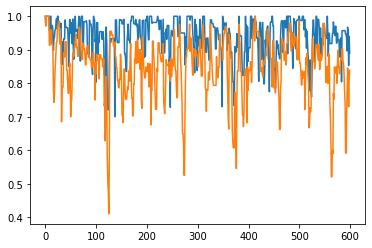

In [37]:
plt.plot(clf_metrics[0][0])
plt.plot(clf_metrics[1][0])
plt.plot(clf_metrics[2][0])
plt.plot(clf_metrics[3][0])

In [ ]:
plt.plot(clf_metrics[0][1])
plt.plot(clf_metrics[1][1])
plt.plot(clf_metrics[2][1])
plt.plot(clf_metrics[3][1])

In [ ]:
plt.plot(clf_metrics[0][2])
plt.plot(clf_metrics[1][2])
plt.plot(clf_metrics[2][2])
plt.plot(clf_metrics[3][2])

In [ ]:
acc

In [ ]:
label_mapping

In [83]:
import ipywidgets as widgets

play = widgets.Play(
    value=0,
    min=0,
    max=len(allmaps),
    step=1,
    interval=500,
    description="Press play",
    disabled=False
)

def f(frame):
    fig, axes = plt.subplots(2,2, figsize=(12,12))
    B = allmaps[frame-1]
    A = allmaps[frame]
    for ax, clf in zip(axes, clfs):
        axis = ax
        centroids, _ = measure_clusters(get_clusters(B, clf))
        axis[0].imshow(B)
        for centr_number, centroid in enumerate(centroids):
            #axis[0].set_title(cnames[0])
            axis[0].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))

        centroids, _ = measure_clusters(get_clusters(A, clf))
        simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(B, clf), get_clusters(A, clf))
        axis[1].imshow(A)
        label_mapping = get_cluster_mapping(simmilarities)or {}
        print(label_mapping)
        for centr_number, centroid in enumerate(centroids):
            #axis[1].set_title(cnames[1])
            if centr_number in label_mapping.keys():
                name = str(label_mapping[centr_number])
            else:
                name = 'new'
            axis[1].text(x = centroid[1], y = centroid[0], s=name, bbox=dict(color='white', alpha=0.1))
    


slider = widgets.IntSlider(value=0, min=0, max=len(allmaps))
widgets.jslink((play, 'value'), (slider, 'value'))
out = widgets.interactive_output(f, {'frame': slider})
widgets.VBox([out, widgets.VBox([play, slider])])

In [ ]:
data_dbscan = []
clf = dbscan
for frame in range(1,len(allmaps)):
    B = allmaps[frame-1]
    A = allmaps[frame]
    centroids, _ = measure_clusters(get_clusters(A, clf))
    simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(B, clf), get_clusters(A, clf))
    label_mapping = get_cluster_mapping(simmilarities) if simmilarities is not None else {}
    old_clusters = 0
    new_clusters = 0
    for centr_number, centroid in enumerate(centroids):
        if centr_number in label_mapping.keys():
            old_clusters += 1
        else:
            new_clusters += 1
    data_dbscan.append((frame, old_clusters, new_clusters))

In [ ]:
data_optics = []
clf = optics
for frame in range(1,len(allmaps)):
    B = allmaps[frame-1]
    A = allmaps[frame]
    centroids, _ = measure_clusters(get_clusters(A, clf))
    simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(B, clf), get_clusters(A, clf))
    label_mapping = get_cluster_mapping(simmilarities) if simmilarities is not None else {}
    old_clusters = 0
    new_clusters = 0
    for centr_number, centroid in enumerate(centroids):
        if centr_number in label_mapping.keys():
            old_clusters += 1
        else:
            new_clusters += 1
    data_optics.append((frame, old_clusters, new_clusters))

In [ ]:
do = np.array(data_optics)
dd = np.array(data_dbscan)

In [ ]:
do[:,1].sum(), dd[:,1].sum()

In [ ]:
do[:,2].sum(), dd[:,2].sum()

In [ ]:
do.shape

In [ ]:
def get_bar_progress(data_):
    fig, axe = plt.subplots(1,1,figsize=(8,6))
    width = 1.
    old = data_[:,1][:300]
    new = data_[:, 2][:300]
    ind = range(old.shape[0])

    p1 = axe.bar(ind, old, width, label="old cluster")
    p2 = axe.bar(ind, new, width, bottom = old, label="new clusters")
    axe.set_xlim(0,300)
    axe.set_ylim(0,16)
    axe.legend()
#plt.xticks(ind)

In [ ]:
get_bar_progress(do)

In [ ]:
get_bar_progress(dd)

In [ ]:
plt.plot(do[:,1])
plt.plot(do[:,2])

In [ ]:
plt.plot(dd[:,1])
plt.plot(dd[:,2])

In [ ]:
def categorised(map_matrix, clustering_algorithm):
    clustered_points = get_clusters(map_matrix, clustering_algorithm)
    clustered_points[:, 0][clustered_points[:, 0] != -1 ] = 1
    clustered_points[:, 0][clustered_points[:, 0] == -1 ] = 0
    return clustered_points

In [ ]:
clstrd = categorised(B, optics)

In [ ]:
from sklearn.metrics import log_loss
log_loss([0,1,1,1], [0,1,1,1])

In [ ]:
class metalern(OPTICS):
    def __init__(self,min_samples=5, max_eps=np.inf, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, n_jobs=None):
        OPTICS.__init__(self, min_samples, max_eps, metric, p, metric_params, cluster_method, eps, xi, predecessor_correction, min_cluster_size, algorithm, leaf_size, n_jobs)
        
    def predict(self, x):
        self.fit(x)
        clustered_points = np.hstack((
                                self.labels_.reshape(-1,1),
                                x
                                ))
        clustered_points
        clustered_points[:, 0][clustered_points[:, 0] != -1 ] = 1
        clustered_points[:, 0][clustered_points[:, 0] == -1 ] = 0
        return clustered_points
        
        

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)



In [ ]:
def listify(map_matrix):
    map_points = np.array(
                    sorted(list(
                        zip(np.where(map_matrix != 0)[0],
                            np.where(map_matrix != 0)[1])
                    )))
    
    if len(map_points) == 0:
        return []
    else:
        return map_points

In [ ]:
real = [listify(x) for x in allmaps]
realy = [x[:,0] for x in allmaps_possible_clusterpoints]

In [ ]:
def predict(clf, x):
    clf.fit(x)
    clustered_points = np.hstack((
                            clf.labels_.reshape(-1,1),
                            x
                            ))
    clustered_points[:, 0][clustered_points[:, 0] != -1 ] = 1
    clustered_points[:, 0][clustered_points[:, 0] == -1 ] = 0
    return clustered_points

In [ ]:
real_pred = [predict(dbscan, x) for x in real]

In [93]:
realy

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 1,

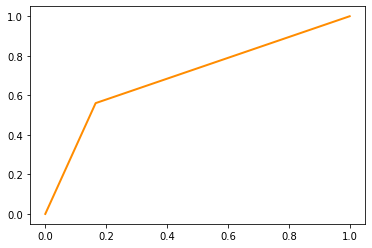

In [99]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2)

In [100]:
np_real_pred = np.concatenate(real_pred)[:,0]
np_truth = np.concatenate(realy)

In [106]:
np_real_pred.shape[0]

24555

In [114]:
pred_y

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

In [110]:
pred_y = np.split(np_real_pred[:24500],245)
truth_y = np.split(np_truth[:24500],245)

In [111]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(pred_y,truth_y)

ValueError: multiclass-multioutput format is not supported

In [79]:
get_clusters

[array([[ 58,  10],
        [ 58,  11],
        [ 59,  12],
        [ 60,  12],
        [ 61,  13],
        [ 61,  14],
        [ 62,  15],
        [ 63,  15],
        [ 65,  17],
        [ 66,  18],
        [ 67,  19],
        [ 68,  20],
        [ 69,  20],
        [ 70,  95],
        [ 72,  91],
        [ 74,  88],
        [ 78,  95],
        [ 80,  88],
        [ 82,  91],
        [161, 132],
        [163, 130],
        [164, 130],
        [165, 131],
        [165, 133],
        [168, 131],
        [168, 135],
        [169, 128],
        [228, 155],
        [229, 156],
        [230, 156],
        [233, 158],
        [234, 158],
        [235, 159],
        [239, 161],
        [243, 163],
        [247, 165]]), array([[ 58,  10],
        [ 58,  11],
        [ 59,  12],
        [ 60,  12],
        [ 61,  13],
        [ 61,  14],
        [ 62,  15],
        [ 63,  15],
        [ 65,  17],
        [ 66,  18],
        [ 67,  19],
        [ 68,  20],
        [ 69,  20],
        [ 70,  95],

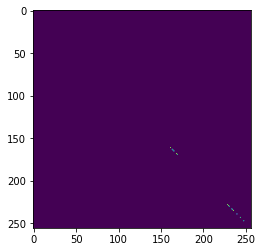

In [38]:
img = np.zeros((256,256))
img[real[1][:,0],real[1][:,0]] = realy[1]
plt.imshow(img)

In [44]:
from sklearn.metrics import log_loss, accuracy_score
import itertools

def score_grid(cls, grid):
    grid_score = {}
    for min_samples, eps in tqdm(itertools.product(*grid)):
        clf = cls(min_samples=min_samples, eps=eps)
        cv_acc = []
        for x,y in tqdm(zip(real, realy)):
            clf.fit(x)
            clustered_points = np.hstack((
                                    clf.labels_.reshape(-1,1),
                                    x
                                    ))
            clustered_points[:, 0][clustered_points[:, 0] != -1 ] = 1
            clustered_points[:, 0][clustered_points[:, 0] == -1 ] = 0
            ypred = clustered_points[:,0]
            cv_acc.append(accuracy_score(y, ypred))
        grid_score[(min_samples, eps)] = np.mean(cv_acc)
    return grid_score

In [53]:
grid = [(1,3,5,8, 10),[None]]

optics_score = score_grid(OPTICS, grid)
grid = [(1,5,8, 10),[1.,4., 5.,8.]]
dbscan_score = score_grid(DBSCAN, grid)

In [50]:
optics_score

{(1, None): 0.2854711623382141,
 (3, None): 0.4865411913266174,
 (5, None): 0.5342202236418417,
 (8, None): 0.574054736553306,
 (10, None): 0.563801361074182}

In [51]:
dbscan_score

{(1, 1.0): 0.2854711623382141,
 (1, 5.0): 0.2854711623382141,
 (1, 8.0): 0.2854711623382141,
 (5, 1.0): 0.7148087418937726,
 (5, 5.0): 0.7252618759857745,
 (5, 8.0): 0.7425082267513524,
 (8, 1.0): 0.714528837661786,
 (8, 5.0): 0.7058006386024019,
 (8, 8.0): 0.7122293213219845,
 (10, 1.0): 0.714528837661786,
 (10, 5.0): 0.7015202200985327,
 (10, 8.0): 0.7042464050856381}

In [395]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {
    'min_samples':[1,5,8], 
    'metric':[ 'cosine', 'euclidean',a 'l2'],
    'eps': [1., 5., 8.]
}
mtl = metalern()
clf = GridSearchCV(mtl, parameters, scoring="accuracy")
clf.fit(real[4], realy[4])



/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass min_samples=5, max_eps=inf, metric=minkowski, p=2, metric_params=None, cluster_method=xi, eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm=auto, leaf_size=30, n_jobs=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/home/mwm/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 202, in accur

GridSearchCV(estimator=metalern(),
             param_grid={'eps': [1.0, 5.0, 8.0],
                         'metric': ['cosine', 'euclidean', 'l2'],
                         'min_samples': [1, 5, 8]},
             scoring='accuracy')

In [272]:
clf.best_estimator_

SVC(C=1, kernel='linear')

# End compare

In [100]:
dist

array([[0.        , 0.        , 0.        , 0.        ],
       [0.82010806, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.98141741, 0.        ]])

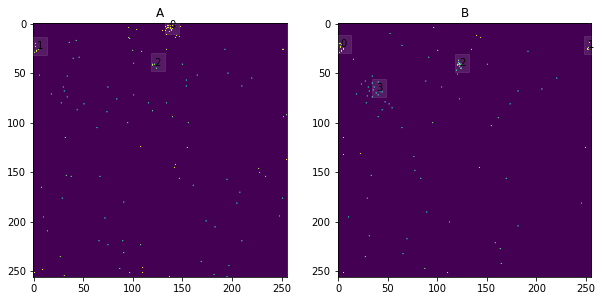

In [101]:


fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
cnames = ['A','B']
centroids, _ = measure_clusters(get_clusters(B, dbscan))
axis[0].imshow(B)
for centr_number, centroid in enumerate(centroids):
    axis[0].set_title(cnames[0])
    axis[0].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))
    
centroids, _ = measure_clusters(get_clusters(A, dbscan))
axis[1].imshow(A)
for centr_number, centroid in enumerate(centroids):
    axis[1].set_title(cnames[1])
    axis[1].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))

In [22]:
shape.shape

AttributeError: 'NoneType' object has no attribute 'shape'

ValueError: Must pass 2-d input. shape=()

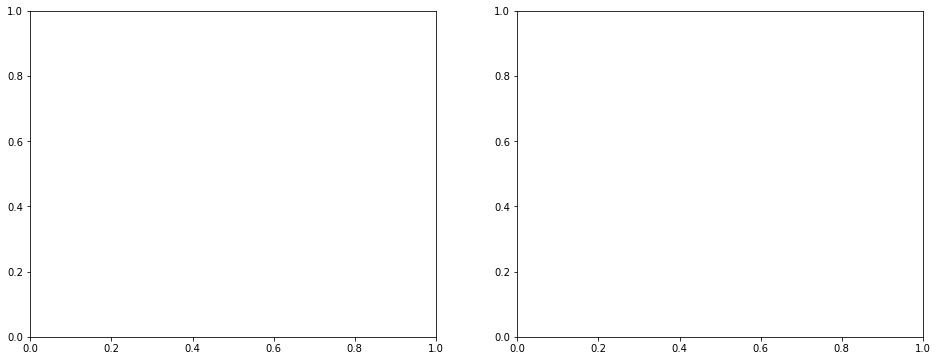

In [23]:
fig, axis = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(dist, ax = axis[0])
axis[0].set_title('distance similairites')
sns.heatmap(shape, ax = axis[1])
axis[1].set_title('shape similairites')
axis[0].set_xlabel('B')
axis[0].set_ylabel('A')
axis[1].set_xlabel('B')
axis[1].set_ylabel('A')

Text(51.0, 0.5, 'A')

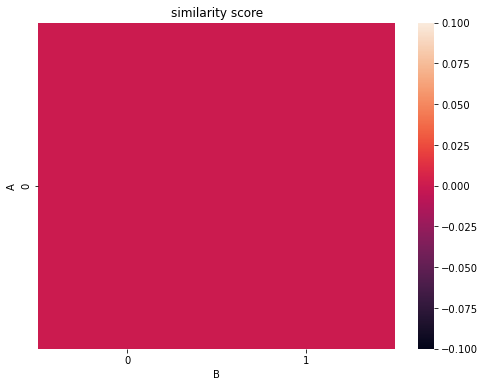

In [24]:
fig, axis = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(simmilarities, ax=axis)
axis.set_title('similarity score')
axis.set_xlabel('B')
axis.set_ylabel('A')

Text(51.0, 0.5, 'A')

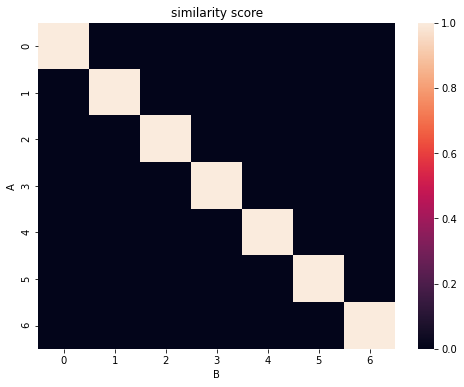

In [41]:
fig, axis = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(find_strong_max(simmilarities), ax=axis)
axis.set_title('similarity score')
axis.set_xlabel('B')
axis.set_ylabel('A')

NameError: name 'cnames' is not defined

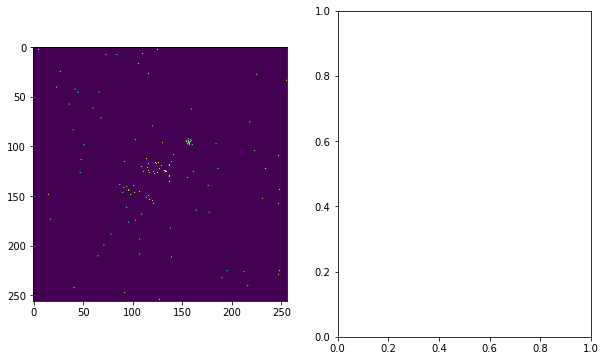

In [41]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

centroids, _ = measure_clusters(get_clusters(B, dbscan))
axis[0].imshow(B)
for centr_number, centroid in enumerate(centroids):
    axis[0].set_title(cnames[0])
    axis[0].text(x = centroid[1], y = centroid[0], s=str(centr_number), bbox=dict(color='white', alpha=0.1))
    
centroids, _ = measure_clusters(get_clusters(A, dbscan))
axis[1].imshow(A)
label_mapping = get_cluster_mapping(simmilarities)
for centr_number, centroid in enumerate(centroids):
    axis[1].set_title(cnames[1])
    if centr_number in label_mapping.keys():
        name = str(label_mapping[centr_number])
    else:
        name = 'new'
    axis[1].text(x = centroid[1], y = centroid[0], s=name, bbox=dict(color='white', alpha=0.1))

# Phase 1

### Novelty

In [60]:
def new_and_lost_clusters_between(curr_map, prev_map, dbscan):
    simmilarities, (dist, shape) = cluster_simmilarity(get_clusters(curr_map, dbscan),
                                                       get_clusters(prev_map, dbscan))
    if simmilarities is None:
        return 0, 0
    
    cluster_pairs_matrix = find_strong_max(simmilarities)
    
    new = np.where(np.sum(cluster_pairs_matrix, axis = 0) == 0)[0].shape[0]
    lost = np.where(np.sum(cluster_pairs_matrix, axis = 1) == 0)[0].shape[0]
    return new, lost


def novelty_measures(curr_map, prev_map, dbscan):
    new_points_count = np.sum(np.clip(curr_map-prev_map, a_min=0, a_max=1))
    lost_points_count = np.sum(np.clip(prev_map-curr_map, a_min=0, a_max=1))
    
    number_of_new_clusters, number_of_lost_clusters = new_and_lost_clusters_between(curr_map, prev_map, dbscan)
    
    curr_clusters = get_clusters(curr_map, dbscan)
    curr_clusters = curr_clusters[np.where(curr_clusters[:,0] != -1)]
    prev_clusters = get_clusters(prev_map, dbscan)
    prev_clusters = prev_clusters[np.where(prev_clusters[:,0] != -1)]
    points_in_clusters_shared = np.vstack((curr_clusters, prev_clusters)).shape[0] \
                            - np.unique(np.vstack((curr_clusters, prev_clusters)), axis=0).shape[0]
    new_points_in_clusters_count = curr_clusters.shape[0] - points_in_clusters_shared
    lost_points_in_clusters_count = prev_clusters.shape[0] - points_in_clusters_shared
    
    return (new_points_count,
            lost_points_count,
            number_of_new_clusters,
            number_of_lost_clusters,
            new_points_in_clusters_count,
            lost_points_in_clusters_count)
    


In [61]:
novelty_measures(A, B, dbscan)

(44.0, 72.0, 2, 0, 5, 38)

### Outlierness